# MVP

In [1]:
# General Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# AWS Libraries
import logging
import boto3
from botocore.exceptions import ClientError

# NLP Libraries
import unicodedata
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from wordcloud import WordCloud

# Geo-mapping Libraries
import geopandas
import geopy
import folium 

# Helper Functions
import MVP_acquire_ds, MVP_explore

# Skill Libray
import library

import warnings
warnings.filterwarnings("ignore")

## Data Acquisition

### Download the JSON Files from AWS S3 Bucket

In [2]:
# Create the s3 resource object
s3 = boto3.resource('s3')

# Download the json files from AWS

s3.Bucket("dspreparedjobpostings").download_file("df_ds_tx_prepared_backup.json", 
                                                 "df_ds_tx_prepared_backup.json")

# Print the last modified datetime of the prepared file of data scientist positions in TX
print("Last modified datetime for data scientist positions in TX: ", 
      s3.Object('dspreparedjobpostings', 'df_ds_tx_prepared_backup.json').last_modified)

s3.Bucket("wdpreparedjobpostings").download_file("df_wd_tx_prepared_backup.json", 
                                                 "df_wd_tx_prepared_backup.json")

# Print the last modified datetime of the prepared file of web developer positions in TX
print("Last modified datetime for web developer positions in TX: ", 
      s3.Object('wdpreparedjobpostings', 'df_wd_tx_prepared_backup.json').last_modified)

Last modified datetime for data scientist positions in TX:  2021-03-12 04:34:27+00:00
Last modified datetime for web developer positions in TX:  2021-03-12 04:37:27+00:00


## Data Preparation

### Load JSON Files into Dataframe and Set the Date as the Index

In [3]:
# Read the json file and convert it to pandas dataframe

df_ds = pd.read_json('df_ds_tx_prepared_backup.json')
df_wd = pd.read_json('df_wd_tx_prepared_backup.json')

# Set the date column as the index and sort the index

df_ds.date = pd.to_datetime(df_ds.date)
df_ds = df_ds.set_index('date').sort_index(ascending=False)
df_wd.date = pd.to_datetime(df_wd.date)
df_wd = df_wd.set_index('date').sort_index(ascending=False)

# Print the number of job postings in each dataframe

print("Number of data scientist job postings in TX: ", df_ds.shape[0])
print("Number of web developer job postings in TX: ", df_wd.shape[0])

Number of data scientist job postings in TX:  2790
Number of web developer job postings in TX:  5499


In [4]:
# Print the concise summary of the dataframe df_ds
df_ds.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2790 entries, 2021-03-11 to 2020-12-22
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   title            2790 non-null   object 
 1   company          2790 non-null   object 
 2   company_rating   2790 non-null   float64
 3   job_link         2790 non-null   object 
 4   job_description  2790 non-null   object 
 5   city             2790 non-null   object 
 6   state            2790 non-null   object 
 7   zipcode          2790 non-null   int64  
 8   clean            2790 non-null   object 
dtypes: float64(1), int64(1), object(7)
memory usage: 218.0+ KB


In [5]:
# Print the concise summary of the dataframe df_wd
df_wd.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5499 entries, 2021-03-11 to 2021-01-04
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   title            5499 non-null   object 
 1   company          5499 non-null   object 
 2   company_rating   5499 non-null   float64
 3   job_link         5499 non-null   object 
 4   job_description  5499 non-null   object 
 5   city             5499 non-null   object 
 6   state            5499 non-null   object 
 7   zipcode          5499 non-null   int64  
 8   clean            5499 non-null   object 
dtypes: float64(1), int64(1), object(7)
memory usage: 429.6+ KB


In [6]:
# Print the first 5 rows of the dataframe df_ds
df_ds.head()

,title,company,company_rating,job_link,job_description,city,state,zipcode,clean
date,,,,,,,,,
2021-03-11,Data Scientist,Bell Textron Inc.,3.9,https://www.indeed.com/rc/clk?jk=b23879cb89da3...,Data Scientist\n290303\nWe are pioneers. We we...,Fort Worth,TX,0,data scientist 290303 pioneer first break soun...
2021-03-11,Machine Learning Engineer,mroads,3.2,https://www.indeed.com/company/MRoads/jobs/Mac...,Responsibilities:Use statistical and machine l...,Plano,TX,75024,responsibilitiesuse statistical machine learni...
2021-03-11,Data Scientist/Machine Learning Engineer,Calance US,3.8,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,"FOR IMMEDIATE DETAILS ABOUT THIS POSITION, con...",Plano,TX,0,immediate detail position contact u direct ref...
2021-03-11,Sr. Supply Chain Data Scientist / Grand Prairi...,LOCKHEED MARTIN CORPORATION,4.0,https://www.indeed.com/rc/clk?jk=a428e20558d8e...,"Designs, develops, automates, and maintains Su...",Grand Prairie,TX,75051,design develops automates maintains supply cha...
2021-03-11,Junior Software Engineer - Corporate Technolog...,"JPMorgan Chase Bank, N.A.",3.9,https://www.indeed.com/rc/clk?jk=a152d277f1831...,"As a member of our Software Engineering Group,...",Lewisville,TX,0,member software engineering group look first f...


In [7]:
# Print the first 5 rows of the dataframe df_wd
df_wd.head()

,title,company,company_rating,job_link,job_description,city,state,zipcode,clean
date,,,,,,,,,
2021-03-11,Senior QNXT Developer,Gainwell Technologies,3.0,https://www.indeed.com/rc/clk?jk=3ad8d91a8f285...,Job Description:\nEssential Job Functions\nDes...,Remote,TX,0,job description essential job function design ...
2021-03-11,Senior Application Developer (full-stack),Performant Solutions,3.7,https://www.indeed.com/rc/clk?jk=b6a135cfb086f...,Senior Applications Developer\nWe love asking ...,Austin,TX,0,senior application developer love asking senio...
2021-03-11,Software Engineer (Java Developer),M3TEKSYSTEMS INC,3.7,https://www.indeed.com/company/M3TEKSYSTEMS/jo...,We are looking for a experience Software Engin...,Sugar Land,TX,77479,looking experience software engineer java deve...
2021-03-11,Senior Software Engineer - IT (Design Analytic...,Dell Technologies,4.0,https://www.indeed.com/rc/clk?jk=585d4c956d35e...,Senior Software Engineer - IT (Design Analytic...,Round Rock,TX,0,senior software engineer design analytics team...
2021-03-11,Software Engineer PHP,Animal Supply Company,2.9,https://www.indeed.com/rc/clk?jk=310cb07b933bb...,Software Engineer PHP\nCorporate Office - Las ...,Irving,TX,75039,software engineer php corporate office la coli...


### Brief Summary of the Job Postings

#### Data Scientist Position

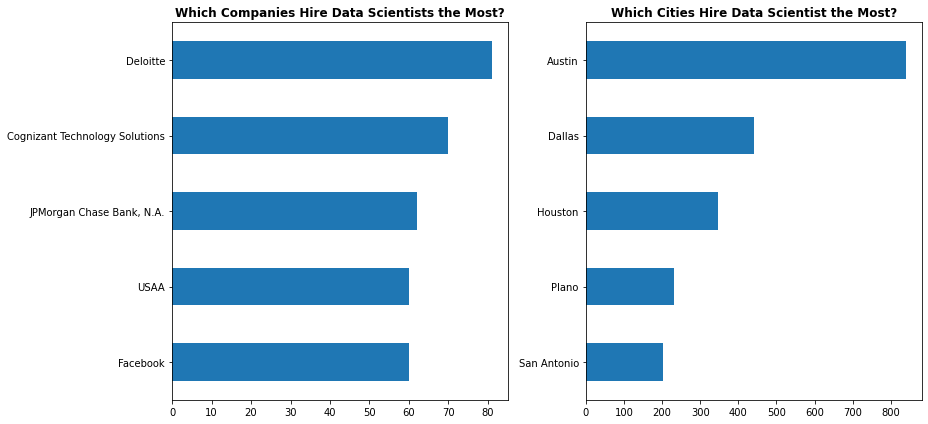

In [8]:
# Barplot the top 5 companies and top 5 cities by the number of the job posts

plt.figure(figsize=(13,6))

plt.subplot(121)
top_companies = df_ds.company.value_counts().head(5)
top_companies.sort_values().plot(kind='barh')
plt.title("Which Companies Hire Data Scientists the Most?", fontweight='bold')

plt.subplot(122)
top_cities = df_ds.city.value_counts().head(5)
top_cities.sort_values().plot(kind='barh')
plt.title("Which Cities Hire Data Scientist the Most?", fontweight='bold')

plt.tight_layout()
plt.show()

In [9]:
# How does the number of job postings change over time?
df_ds.resample('W').title.count()

date
2020-12-27    392
2021-01-03    136
2021-01-10    212
2021-01-17    187
2021-01-24    352
2021-01-31    295
2021-02-07    269
2021-02-14    302
2021-02-21    183
2021-02-28    223
2021-03-07    182
2021-03-14     57
Freq: W-SUN, Name: title, dtype: int64

In [10]:
# Which company has the best avereage rating? 
df_ds.groupby('company').company_rating.mean().sort_values(ascending=False).head()

company
Digital Pharmacist    5.0
Rekruiters            5.0
Onit                  4.7
Levelset              4.7
Harnham               4.6
Name: company_rating, dtype: float64

In [11]:
df_ds.title.value_counts().head()

Data Scientist               296
Senior Data Scientist        107
Senior Data Analyst           64
Machine Learning Engineer     58
Sr. Data Scientist            46
Name: title, dtype: int64

#### Web Developer Position

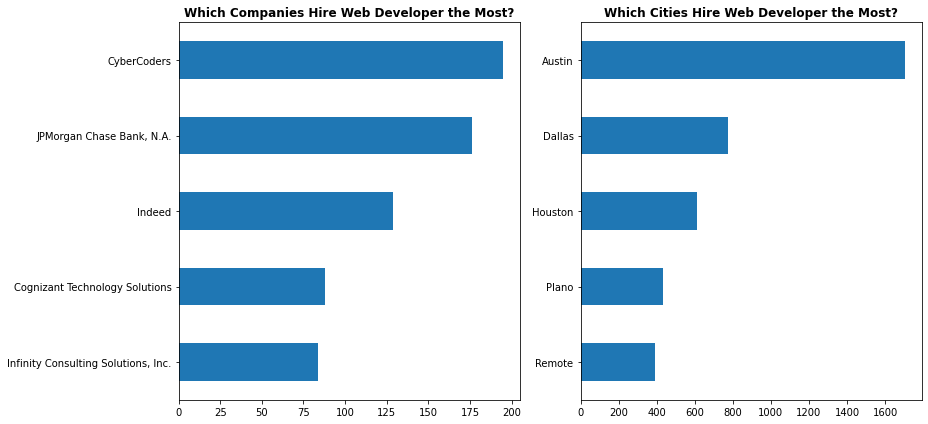

In [12]:
# Barplot the top 5 companies and top 5 cities by the number of the job posts

plt.figure(figsize=(13,6))

plt.subplot(121)
top_companies = df_wd.company.value_counts().head(5)
top_companies.sort_values().plot(kind='barh')
plt.title("Which Companies Hire Web Developer the Most?", fontweight='bold')

plt.subplot(122)
top_cities = df_wd.city.value_counts().head(5)
top_cities.sort_values().plot(kind='barh')
plt.title("Which Cities Hire Web Developer the Most?", fontweight='bold')

plt.tight_layout()
plt.show()

In [13]:
# How does the number of job postings change over time?
df_wd.resample('W').title.count()

date
2021-01-10      62
2021-01-17     346
2021-01-24     793
2021-01-31    1054
2021-02-07     825
2021-02-14     786
2021-02-21     452
2021-02-28     520
2021-03-07     477
2021-03-14     184
Freq: W-SUN, Name: title, dtype: int64

In [14]:
# Which company has the best avereage rating? 
df_wd.groupby('company').company_rating.mean().sort_values(ascending=False).head()

company
Webhead                5.0
MarketScale            5.0
Royal & Ross           5.0
RightNow Ministries    5.0
Rekruiters             5.0
Name: company_rating, dtype: float64

In [15]:
df_wd.title.value_counts().head()

Web Developer               130
Software Engineer           121
Software Developer           87
Senior Software Engineer     86
Full Stack Developer         82
Name: title, dtype: int64

### Top k Needed Skills

#### Data Scientist Position
- Tech Skills
- Soft Skills
- General Skills (Combination of Tech+Soft)

In [16]:
# Import library
ds_tech_library = library.library_ds_tech

# Print the number of skills in the library
print("Number of data science skills in tech skill library: ", len(ds_tech_library))

# Print the top 5 needed tech skills

ds_top_tech = MVP_explore.top_skills(df_ds, 5, ds_tech_library, 'tech')
ds_top_tech

Number of data science skills in tech skill library:  71
Do you want to save the dataframe as JSON and upload to AWS? (Y/N)
y
Enter the INITIALS of the job title:
ds


,top5_tech_skills,frequency
0,machine learning,4200.0
1,python,2258.0
2,sql,1694.0
3,aws,1356.0
4,r,1240.0


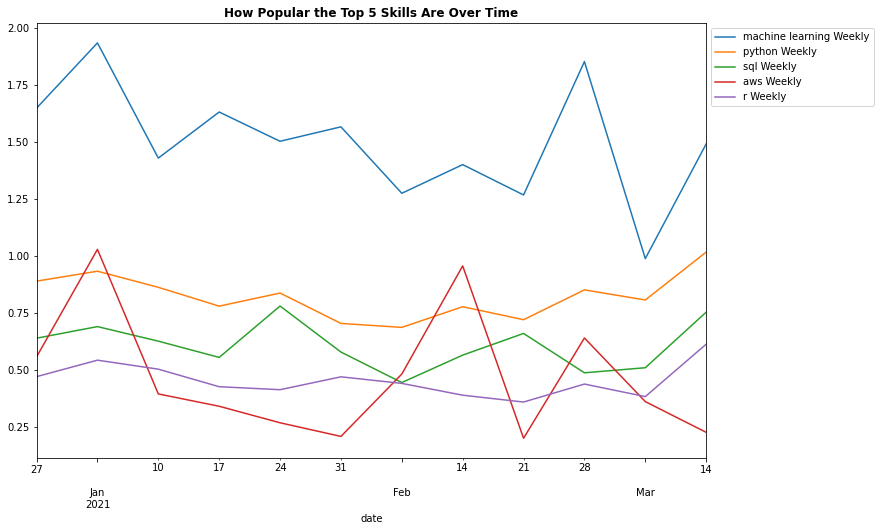

In [17]:
# Plot the how the frequency of the skills per observation change over time

df_ds_skills = MVP_explore.add_skill_frequency(df_ds, ds_top_tech)
MVP_explore.plot_top_skill_ts(df_ds_skills, ds_top_tech)

In [18]:
# Import library
ds_soft_library = library.library_ds_soft

# Print the number of skills in the library
print("Number of data science skills in soft skill library: ", len(ds_soft_library))

# Print the top 5 needed soft skills

ds_top_soft = MVP_explore.top_skills(df_ds, 5, ds_soft_library, 'soft')
ds_top_soft

Number of data science skills in soft skill library:  20
Do you want to save the dataframe as JSON and upload to AWS? (Y/N)
y
Enter the INITIALS of the job title:
ds


,top5_soft_skills,frequency
0,communication,1901.0
1,leadership,1241.0
2,collaboration,551.0
3,problem solving,416.0
4,written communication,320.0


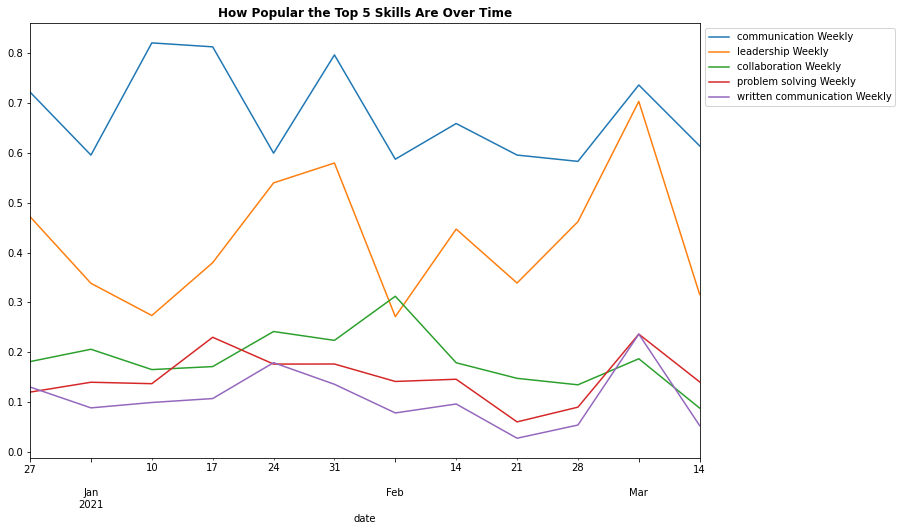

In [19]:
# Plot the how the frequency of the skills per observation change over time

df_ds_skills = MVP_explore.add_skill_frequency(df_ds, ds_top_soft)
MVP_explore.plot_top_skill_ts(df_ds_skills, ds_top_soft)

In [20]:
# Import library
ds_general_library = library.library_ds_general

# Print the number of skills in the library
print("Number of data science skills in general skills library: ", len(ds_general_library))

# Print the top 5 needed general skills

ds_top_general = MVP_explore.top_skills(df_ds, 5, ds_general_library, 'general')
ds_top_general

Number of data science skills in general skills library:  90
Do you want to save the dataframe as JSON and upload to AWS? (Y/N)
y
Enter the INITIALS of the job title:
ds


,top5_general_skills,frequency
0,machine learning,4200.0
1,python,2258.0
2,communication,1901.0
3,sql,1694.0
4,aws,1356.0


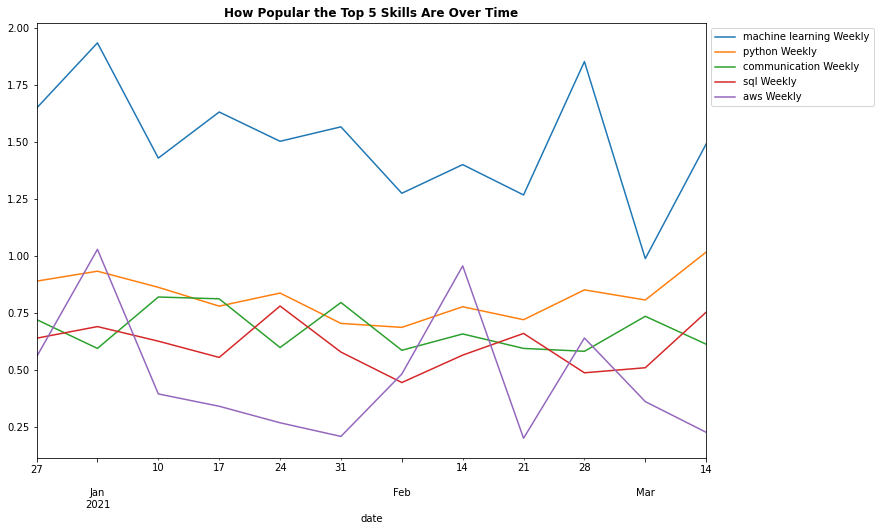

In [21]:
# Plot the how the frequency of the skills per observation change over time

df_ds_skills = MVP_explore.add_skill_frequency(df_ds, ds_top_general)
MVP_explore.plot_top_skill_ts(df_ds_skills, ds_top_general)

#### Web Developer Position
- Tech skills
- Soft skills
- General Skills (Combination of Tech+Soft)

In [22]:
# Import library
wd_tech_library = library.library_wd_tech

# Print the number of skills in the library
print("Number of web dev skills in tech skill library: ", len(wd_tech_library))

# Print the top 5 needed tech skills

wd_top_tech = MVP_explore.top_skills(df_wd, 5, wd_tech_library, 'tech')
wd_top_tech

Number of web dev skills in tech skill library:  67
Do you want to save the dataframe as JSON and upload to AWS? (Y/N)
y
Enter the INITIALS of the job title:
wd


,top5_tech_skills,frequency
0,javascript,4326.0
1,java,2911.0
2,sql,2641.0
3,react,2342.0
4,net,2187.0


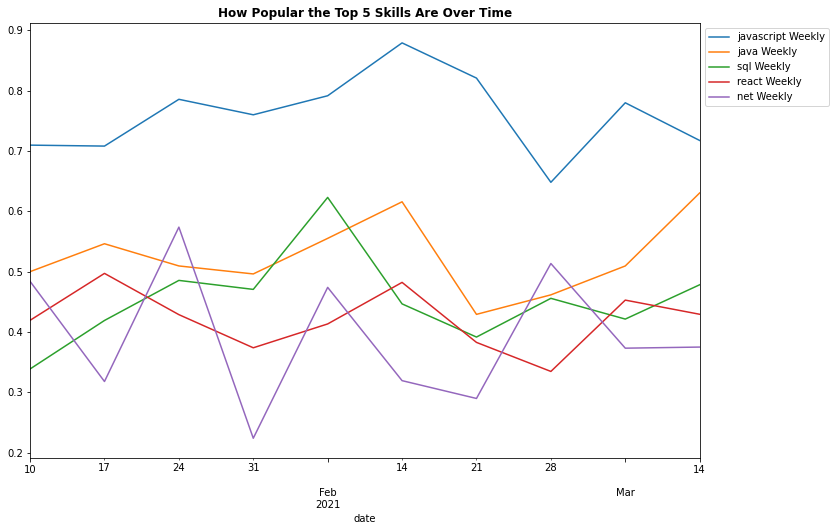

In [23]:
# Plot the how the frequency of the skills per observation change over time

df_wd_skills = MVP_explore.add_skill_frequency(df_wd, wd_top_tech)
MVP_explore.plot_top_skill_ts(df_wd_skills, wd_top_tech)

In [24]:
# Import library
wd_soft_library = library.library_wd_soft

# Print the number of skills in the library
print("Number of web dev skills in soft skill library: ", len(wd_soft_library))

# Print the top 5 needed soft skills

wd_top_soft = MVP_explore.top_skills(df_wd, 5, wd_soft_library, 'soft')
wd_top_soft

Number of web dev skills in soft skill library:  20
Do you want to save the dataframe as JSON and upload to AWS? (Y/N)
y
Enter the INITIALS of the job title:
wd


,top5_soft_skills,frequency
0,communication,3224.0
1,leadership,1241.0
2,collaboration,850.0
3,problem solving,680.0
4,written communication,488.0


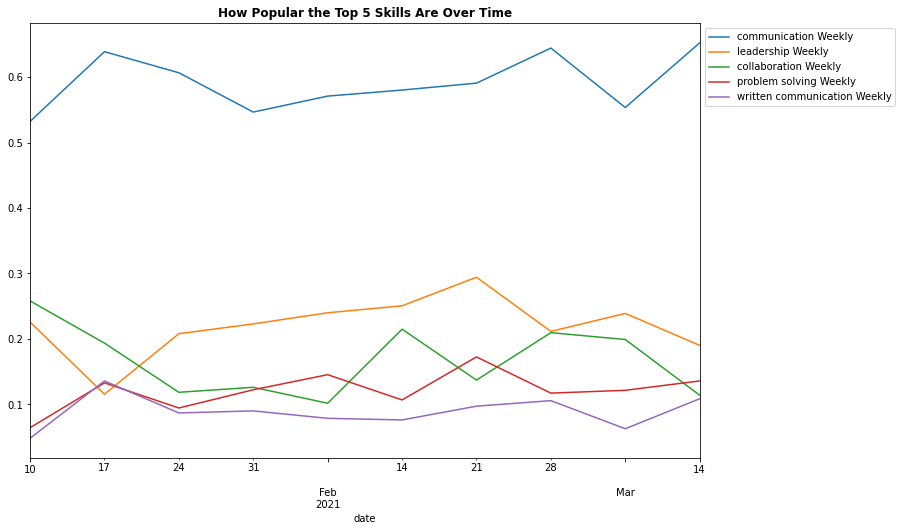

In [27]:
# Plot the how the frequency of the skills per observation change over time

df_wd_skills = MVP_explore.add_skill_frequency(df_wd, wd_top_soft)
MVP_explore.plot_top_skill_ts(df_wd_skills, wd_top_soft)

In [26]:
# Import library
wd_general_library = library.library_wd_general

# Print the number of skills in the library
print("Number of web dev skills in general skill library: ", len(wd_general_library))

# Print the top 5 needed general skills

wd_top_general = MVP_explore.top_skills(df_wd, 5, wd_general_library, 'general')
wd_top_general

Number of web dev skills in general skill library:  86
Do you want to save the dataframe as JSON and upload to AWS? (Y/N)
y
Enter the INITIALS of the job title:
wd


,top5_general_skills,frequency
0,javascript,4326.0
1,communication,3224.0
2,java,2911.0
3,sql,2641.0
4,react,2342.0


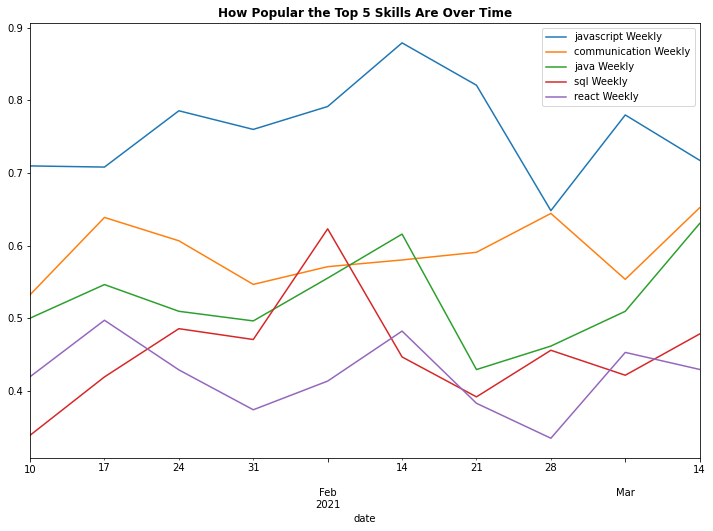

In [28]:
# Plot the how the frequency of the skills per observation change over time

df_wd_skills = MVP_explore.add_skill_frequency(df_wd, wd_top_general)
MVP_explore.plot_top_skill_ts(df_wd_skills, wd_top_general)